In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE

import utils

# Predicting Song Popularity

Now that the data has been cleaned, preprocessed and expanded with new fetures, it's time to start experimenting with the data. As mentioned, the goal is to see how effectively a song can be predicted to be a top 10 hit by using different audio features and spotify popularity metrics.

Target variable is the `top_10_hit` categorical column. Value 1 means that the song has reached the top 10 of the chart during its lifespan on it, while 0 means it didn't. The classes are imbalanced, because only a small percentage of songs manage to reach such high position. This needs to be kept in mind when evaluating model performance.

I will exclude `peak_position` and `weeks_on_chart` from my features, as the position directly indicates if a song is in the top 10, while a high value for weeks is also a pretty clear indicator of a song with a high position.

In [4]:
# Load the preprocessed and the original file
data = pd.read_csv("data/preprocessed_data.csv", index_col=0)

# Separate the features and the target variable
X = data.drop(columns=["top_10_hit", "peak_position", "weeks_on_chart"])
y = data["top_10_hit"]

## Evaluating different models

I will test the default performance of different classification models from `sklearn` and then select the one that seems to perform the best to further optimize its performance.

First I will separate the data into a train-test split. Then I will use the custom `get_classification_report` function that prints that fits the test data,  makes a prediction and prints out the classification report.

I will use **SMOTE (Synthetic Minority Over-sampling Technique)** to synthetically generate data for my undersampled class. The synthetic data will only be used during model training, as the testing needs to be performed on only the actualy values to accurately evaluate the model's predictive powers. This should work to improve the intiial model performance by balancing the classes.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [7]:
# Logistic Regression
utils.get_classification_report(LogisticRegression(), X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      5821
           1       0.43      0.76      0.55      1270

    accuracy                           0.78      7091
   macro avg       0.68      0.77      0.70      7091
weighted avg       0.85      0.78      0.80      7091



In [8]:
# Support Vector Classifier
utils.get_classification_report(SVC(), X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      5821
           1       0.44      0.74      0.55      1270

    accuracy                           0.78      7091
   macro avg       0.69      0.77      0.70      7091
weighted avg       0.84      0.78      0.80      7091



In [9]:
# Random Forest Classifier
utils.get_classification_report(RandomForestClassifier(), X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5821
           1       0.55      0.58      0.56      1270

    accuracy                           0.84      7091
   macro avg       0.73      0.74      0.73      7091
weighted avg       0.84      0.84      0.84      7091



In [10]:
# Gaussian Naive Bias
utils.get_classification_report(GaussianNB(), X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.90      0.65      0.76      5821
           1       0.30      0.67      0.41      1270

    accuracy                           0.65      7091
   macro avg       0.60      0.66      0.58      7091
weighted avg       0.79      0.65      0.69      7091



In [11]:
# AdaBoost Classifier
utils.get_classification_report(AdaBoostClassifier(), X_train, X_test, y_train, y_test)

C:\Users\ferad\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.80      0.86      5821
           1       0.43      0.69      0.53      1270

    accuracy                           0.78      7091
   macro avg       0.68      0.75      0.69      7091
weighted avg       0.83      0.78      0.80      7091



### Results

The models' performance differs. 

* The recall and precision for the `0` class is very high for all models because of the class imbalance, as only around 18% of the songs in the test data have reached top 10 at some point in their charting.
* The obvious worst performing model is the `Gaussian Naive Bias`. Accuracy, precision, recall and f-1 score worse than every other model overall.
* `Logistic Regression`, `Support Vector Classifier` and `AdaBoost Classifier` perform very similarly. At first glance they seem to perform pretty good, however the results are deceiving, because of the class imbalance. This means that the ~75% recall score for the hit classification should be taken with a grain of salt, as the precision is only ~43%.
* `Random Forest Classifier` is the overall best-performing model. It has a lower recall score for class `1` than the previous three, but has a higher precision. This means that it identifies less top ten hits, but is more correct overall, as it doesn't missclassify as much. The recall score for the `0` class is higher also because of the smaller number of missclassifications. Its accuracy is also the highest. 

To conclude - the `Random Forest Classifier` performs best, because it may identify less of the top 10 hits (based on the lower recall for the `1` class), but doesn't missclassify that many non-top-10 songs as being in the top 10 (based on the higher precision for the `0` class). For the purposes of the project, that is the more desirable outcome, as it is more important to more correctly identify top 10 hits, while not making too many misclassifications.

## Classification with Random Forest

Predicting top 10 hits will be done using `Random Forest Classifier`. It is an ensemble model that performs good on data that has non-linear realtionships and imbalanced classes and has less risk of overfitting and having a too high bias.

In [14]:
rfc = RandomForestClassifier(random_state=42)

In [15]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5821
           1       0.55      0.58      0.56      1270

    accuracy                           0.84      7091
   macro avg       0.73      0.74      0.73      7091
weighted avg       0.84      0.84      0.84      7091



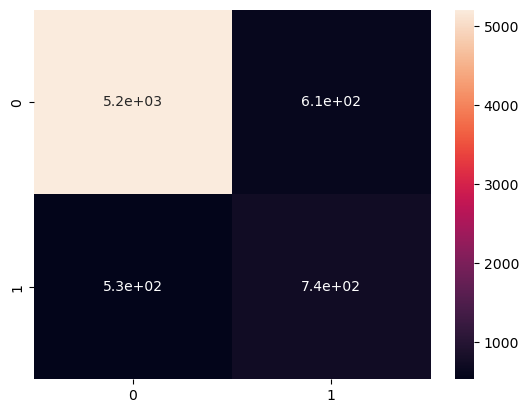

In [17]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

The confusion matrix shows that around 700-750 out of 1270 top 10 songs have been correctly identified, but around 600 songs were missclassified as top 10 hits, when they are not.

The Random Forest with its base parameters tends to have an accuracy of around 83%. This score seems good, but is actually highly inflated, because of the imbalanced classes. This means that if the model randomly guesses class `0`, it has a big chance of making a correct guess, just because that class has a much higher representation in the data. 

### Feature Importance

Lets plot the feature importances on a barchart to identify which of them are the most important in the target predictions.

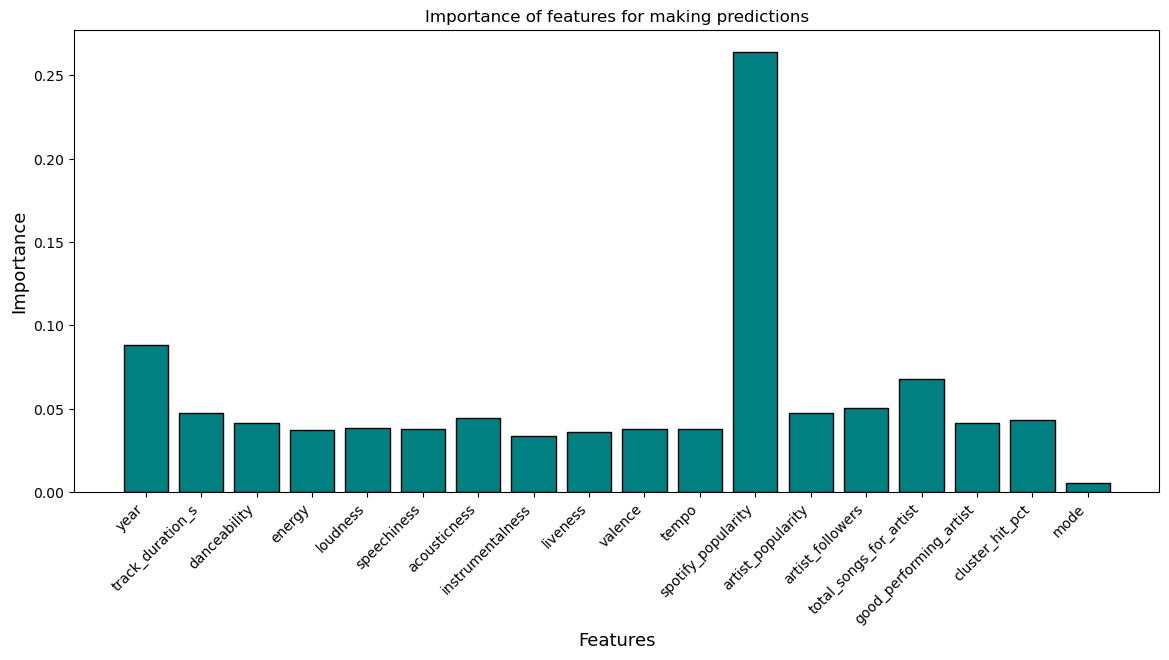

In [20]:
plt.figure(figsize=(14,6))
plt.bar(rfc.feature_names_in_, rfc.feature_importances_, edgecolor="black", color="teal")

plt.xlabel("Features", fontsize=13)
plt.ylabel("Importance", fontsize=13)
plt.title("Importance of features for making predictions")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.show()

* The Spotify popularity is clearly the most important feature for the model.
* The year is the second most important feature, possibly because of the time influence on some audio characteristics and especially on the spotify popularity metrics.
* The `good_performing_artist` indicator and the `cluster_hit_pct` have a surprisingly low impact on the model predictions. The reason for that could be because the two are related to each other, leading to a decrease in their importance.
* The audio characteristics individually have a similar low impact on the model predictions. Among them `acousticness` is the most important.
* The mode has a **very** small impact on predictions.

## Model Optimization

Currently the model performance is not very optimized. It has a high f1 score, precision and recall for class `0` and a high precision, because of the class imbalance, however the underrepresented class `1` is much harder to correctly identify.

My goal is to get a model that missclassifies less non top 10 songs, while also being able to recognize a big amount of the top 10 ones. This means that I will strive for a high precision model, because if means that it doesn't comfuse the classes, but I also need a decent recall score as to be able to predict more top 10 songs. In the end i think that optimizing  for the f1 score will be the best approach, as it measures the balance of precision and recall. This aligns with the goal correctly identify positive samples and also minimize false positives

I will try to improve the model using `RandomSearchCV` to hopefully be able to reach a model performance that identifies more of the hits, while also not missclassifying many non-hits.

In [22]:
# rfc = RandomForestClassifier(random_state=42)

# # Old parameters
# # param_distributions = {
# #     'n_estimators': [50, 100, 150, 200],
# #     'max_depth': [None, 30, 40],
# #     'criterion': ['gini', 'entropy'],
# #     'min_samples_split': [2, 5, 10],
# #     'min_samples_leaf': [1, 2, 4, 6, 8],
# #     'class_weight': [{0: 1, 1: 7}, "balanced", {0: 1, 1: 10}],
# # }

# # New parameters after finding out which ones usually lead to a better model
# param_distributions = {
#     'n_estimators': [50, 200],
#     'max_depth': [None, 20, 30, 40],
#     'criterion': ['gini', "log_loss"],
#     'min_samples_split': [2, 3, 5, 8, 10],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10],
#     'class_weight': ["balanced"],
# }

# random_search = RandomizedSearchCV(
#     estimator=rfc,
#     param_distributions=param_distributions,
#     n_iter=50,
#     cv=4,
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
# )

# random_search.fit(X, y)

# print("Best Parameters:", random_search.best_params_)

The shown best parameters may differ, but after several evaluations using different scoring and different parameter distributions, I came to the conclusion that the model performs best scoring for the `f1_macro` score. Most commonly, the best parameters are a balanced class weight or a 1 to 10 ratio for the different classes, 4-8 minimum samples for per leaf, max depth of 40 or **None**, and **gini** criterion. Using **None** for max features lead to a very slight improvement over **sqrt**.


The most important parameters for having a stable precision-recall balance proved to be the `min_samples_leaf` and `class_weight`.

In [24]:
# Redefine the train-test split without using oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)

In [25]:
rfc = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    criterion="gini",
    max_depth=None,
    min_samples_leaf=6, 
    min_samples_split=4,
    n_estimators=150,
    max_features=None, 
)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      5821
           1       0.57      0.58      0.57      1270

    accuracy                           0.85      7091
   macro avg       0.74      0.74      0.74      7091
weighted avg       0.85      0.85      0.85      7091



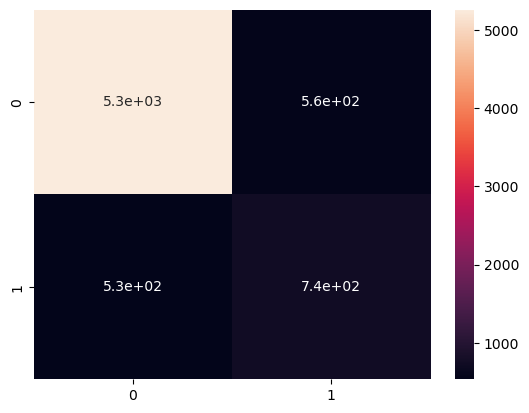

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

The model now missclassifies a little less songs than it did with the base parameters, but the important part is that this result was reached without the use of the synthetic data from SMOTE, which has the possibility of making the model overfit. It is pretty easy for the model to identify more of the top 10 songs, but that comes at the cost of a lot more missclassifications of non top 10. The current optimized model is the more desirable result, as it still identifies a lot of the top 10 songs, while making much less missclassifications, compared to an initial model, which has a higher precision for the `1` class, but noticeably lower precision:

Without the proper hyperparameter tuning, the imbalanced classes lead the model either having a higher precision with a very low recall, meaning that it identifies very little of the hits, or a high recall with very little precision, meaning that the model blindly identifies more songs as hits, leading to more missclassifications.

Now lets perform cross-validation to ensure that the optimized model is not overfitting.

In [32]:
kf = KFold(n_splits=5, shuffle=True)

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    rfc.fit(X_fold_train, y_fold_train)

    y_pred = rfc.predict(X_fold_val)
    
    a = accuracy_score(y_fold_val, y_pred)
    b = precision_score(y_fold_val, y_pred)
    c = recall_score(y_fold_val, y_pred)
    d = f1_score(y_fold_val, y_pred)
    print("fold scores:")
    print(f"Accuracy: {a} | Precision: {b} | Recall: {c} | F1 Score: {d}")

fold scores:
Accuracy: 0.8460634547591069 | Precision: 0.5625790139064475 | Recall: 0.5901856763925729 | F1 Score: 0.5760517799352751
fold scores:
Accuracy: 0.8493537015276146 | Precision: 0.5498721227621484 | Recall: 0.5980528511821975 | F1 Score: 0.5729513657561626
fold scores:
Accuracy: 0.8531139835487661 | Precision: 0.5652173913043478 | Recall: 0.5925414364640884 | F1 Score: 0.5785569790964261
fold scores:
Accuracy: 0.8495533615420781 | Precision: 0.5701754385964912 | Recall: 0.6050531914893617 | F1 Score: 0.5870967741935483
fold scores:
Accuracy: 0.843441466854725 | Precision: 0.5588942307692307 | Recall: 0.6086387434554974 | F1 Score: 0.5827067669172933


The goal is to ensure that the model doesn't have a big difference in the classification scores in the different folds. That is accomplished here, as the values are very similar between models.

For a final attempt at improving the model performance, I will use a `VotingClassifier`, combining multiple Random Forest Classifiers with slightly different parameters.

In [34]:
rf1 = RandomForestClassifier(class_weight="balanced", random_state=42, criterion="gini", max_depth=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200, max_features=None)
rf2 = RandomForestClassifier(class_weight="balanced", random_state=42, criterion="entropy", max_depth=None, min_samples_leaf=8, min_samples_split=5, n_estimators=150)
rf3 = RandomForestClassifier(class_weight="balanced", random_state=42, criterion="gini", max_depth=40, min_samples_leaf=2, min_samples_split=3, n_estimators=150, max_features="log2")
rf4 = RandomForestClassifier(class_weight={0: 1, 1: 7}, random_state=42, criterion="gini", max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=200)
rf5 = RandomForestClassifier(class_weight={0: 1, 1: 8}, random_state=42, criterion="entropy", max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50)


voting_clf = VotingClassifier(estimators=[
    ('rf1', rf1),
    ('rf2', rf2),
    ('rf3', rf3),
    ('rf4', rf4),
    ('rf5', rf5),
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5821
           1       0.58      0.56      0.57      1270

    accuracy                           0.85      7091
   macro avg       0.74      0.73      0.74      7091
weighted avg       0.85      0.85      0.85      7091



The result is a very negligible improvement in the precision and recall - just 1%. 

## Model Evaluation

Overall the results are not that satisfying. The model manages to identify around 750 out of the 1270 top 10 hits, which is a good result overall. The problem comes from the missclassification of around 650 songs as top 10 hits, when they are not. Missclassifying non-top-10 is worse than not recognizing the top 10 songs, because it means that when a song is predicted to be in the top 10, there is a moderate chance that it actually isn't. A better model should be able to identify more of the top 10 songs (higher recall), while not missclassifying more non top 10.

The reason for the model not performing that good is very likely because the features used are just not enough for predicting whether a song enters the top 10. Setting such a high bar for the target class also hinders the model performance, as SMOTE generates synthetic data, which is just an approximation of the actual data, so it doesn't have the dynamic and real relationships between features.

An argument can be made that the audio features actually don't contribute to the model's quality. To see if they actually do I will use the model on just the columns that contain popularity metrics.

In [38]:
X = X.iloc[:, -7:-1] #Select only the `popularity` columns, excluding all audio features
X = X.drop(columns="cluster_hit_pct")
X["year"] = data["year"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)

new_rfc = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    criterion="gini",
    max_depth=None,
    min_samples_leaf=6,
    min_samples_split=4,
    n_estimators=200,
    max_features=None, 
)

new_rfc.fit(X_train, y_train)
y_pred = new_rfc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      5821
           1       0.53      0.66      0.59      1270

    accuracy                           0.83      7091
   macro avg       0.72      0.77      0.74      7091
weighted avg       0.85      0.83      0.84      7091



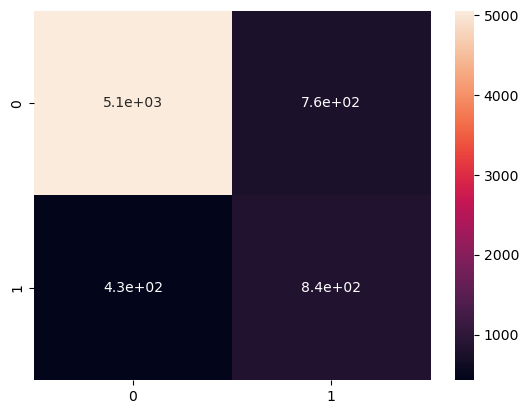

In [39]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

Just a quick look at the `classification report` and `confusion matrix` indicates that the model has a slightly worse overall precision for classifying top 10 hits, than when using the audiio features. Its accuracy is also lower. It missclassifies more non hits as hits, which is the opposite of the goal to missclassify as little as possible.

In [41]:
# Save the model to a file
with open("voting_classifier.pkl", "wb") as f:
    pickle.dump(voting_clf, f)
    
with open("final_forest_classifier.pkl", "wb") as f:
    pickle.dump(rfc, f)